*Copyright (C) 2023 Intel Corporation*<br>
*SPDX-License-Identifier: BSD-3-Clause*<br>
*See: https://spdx.org/licenses/*

---

# Continually Learning Prototypes (CLP) for Object Learning

#### Motivation: 
This tutorial demonstrates the continual learning of objects on real data with our CLP algorithm. 

#### Introduction:

In the context of online continual learning, the approach we refer to as "Continually Learning Prototypes" is an evolving paradigm combining supervised, unsupervised, and semi-supervised learning elements. It begins with a supervised continual learning phase, where the base classes are learned from labeled data. However, it doesn't stop there. This approach seamlessly integrates open-set learning to enhance adaptability and robustness. Overall, it is engineered to meet the evolving challenges of dynamic environments where data may encompass familiar and novel classes.

**Novelty Detection:** One of the core contributions of this approach lies in its novelty detection mechanism, executed through prototype neurons. We implement an open-set learning mechanism by incorporating a threshold mechanism for the prototype neurons. When faced with data from unfamiliar categories, the model detects them as unknown instances. This capability prevents the model from making misguided predictions on novel data. The instance that triggers novelty detection becomes the focal point for further processing.

**Learning Novel Clusters:** The instance that initially triggered the novelty detection serves as the cluster center, capturing the essence of the potentially novel categories or a novel subclass of a known class. The novelty detection mechanism ensures that these clusters are significant departures from known classes.

**User Labeling for Novel Clusters:** The novel clusters identified via unsupervised clustering are labeled through user interactions. A user provides labels for representative instances within each cluster, allowing the model to understand and classify these newly discovered categories. This user-in-the-loop process gradually enriches the model's knowledge over time.

**Few-shot learning:** Thanks to the prototype-based nature of this approach, the model can learn from new or rarely seen categories based on a limited number of examples.

**Adaptation to Dynamic Environments:** This approach is well-suited for dynamic and open-world environments where new classes can emerge unpredictably. Its strength lies in its adaptability and continual learning capacity, ensuring that the model remains relevant and accurate as the environment evolves.

In summary, "Continually Learning Prototypes" combines continual learning, open-set recognition, and user involvement to create a flexible and adaptive learning system. It effectively handles both known and unknown data, making it a valuable asset in applications where the data landscape is ever-changing.

The CLP is based on our previous work on [Interactive continual learning for robots: a neuromorphic approach](https://dl.acm.org/doi/abs/10.1145/3546790.3546791 "Interactive continual learning for robots: a neuromorphic approach") wiht Loihi 1.

#### This tutorial assumes that you:
- have the [Lava framework installed](../../in_depth/tutorial01_installing_lava.ipynb "Tutorial on Installing Lava")
- are familiar with [Process interfaces in Lava](../../in_depth/tutorial02_processes.ipynb "Tutorial on Processes")
- are familiar with [ProcessModel implementations in Lava](../../in_depth/tutorial02_process_models.ipynb "Tutorial on ProcessModels")
- are familiar with how to [connect Lava Processes](../../in_depth/tutorial05_connect_processes.ipynb "Tutorial on connecting Processes")
- are familiar with how to [implement a custom learning rule](../../in_depth/tutorial08_stdp.ipynb "Tutorial on STDP")
- are familiar with how to [implement a reward-modulated learning rule](../../in_depth/three_factor_learning/tutorial01_Reward_Modulated_STDP.ipynb "Tutorial on R-STDP")
- are familiar with [intorductory tutorial on CLP](../../in_depth/clp/tutorial01_one-shot_learning_with_novelty_detection.ipynb "Tutorial on CLP")

#### Overview
In this tutorial, we will extend experiments with CLP to a real dataset. We will still stick to the online continual learning (OCL) setting, where we aim to learn new classes from a stream of non-i.i.d. data, one sample at a time, while not forgetting old classes. Compared to the introductory CLP tutorial, we will use an upgraded version of the algorithm here. Specifically, this version is concurrently capable of both unsupervised and supervised continual learning. We will perform the experiments both in multi-shot and few-shot settings. Crucially, novelty detection will support open-world recognition, where known classes are classified and unknown classes are detected and learned with novelty-triggered one-shot learning. While this constitutes unsupervised continual learning, we also allow the error signal from the user to trigger one-shot learning of the pattern as a type of supervised continual learning. The CLP will learn from the extracted features of a dataset (COIL-100), and we will compare our continual learning results to offline K-NN performance. 

In [2]:
import numpy as np
import matplotlib.pylab as plt

from lava.magma.core.run_configs import Loihi2SimCfg
from lava.magma.core.run_conditions import RunSteps
from lava.proc.dense.process import LearningDense
from lava.proc.dense.models import PyLearningDenseModelBitApproximate

## Dasaset: COIL-100 

<center><img src="https://raw.githubusercontent.com/lava-nc/lava-nc.github.io/main/_static/images/tutorial_clp/coil_100.png" style="width:80%"><center>
<center><figcaption align = "center"> Figure 1. COIL-100 dataset. The dataset includes 72 frames for each of the 100 objects rotated on a turntable. </figcaption><center>

## Data preparation and visualization

### Feature extraction

CLP works on extracted features, so we need to use some feature extractor to process the raw images first. We have a util function ```extract_and_load_features``` that uses the ImageNet-trained EfficientNet backbone for this purpose. Note that you need to install ```torch``` and ```torchvision``` libraries to run feature extraction. Additionally, you need to download the COIL-100 dataset into this tutorial's ```dataset``` folder. You can replace the EfficientNet backbone with any other backbone inside this helper function.

Alternatively, you can set ```extract=False``` to use load pre-extracted features from a file included with this tutorial, bypassing all the above requirements. This file contains extracted features from all objects of the COIL-100 datasets.

The extracted features are put through a few smaller preprocessing steps, e.g., rectification (see the comment in the code below for details).

In [3]:
from utils import extract_and_load_features
# Load COIL-100 data and extract features
X, y = extract_and_load_features(extract=False)

# The label==0 is reserved for "no information" on the communication channel
y = y + 1  

# The negative feature values are clipped to zero. We have validated that this does not degrade accuracy.
X[X<0]=0

# Normalize the vectors
X = X / np.expand_dims(np.linalg.norm(X, axis=1), axis=1)

# The fraction of the fixed point representation used to translate floating point input to graded spikes
b_fraction = 7  
X_fixed = np.round(X * 2 ** b_fraction).astype(np.int32)

# Zero valued neuron is upgraded to '1' so that they can overwrite the x1 trace 
X_fixed = X_fixed + 1  

print(X.shape, y.shape)

LIBS_ARE_AVAILABLE:  True
(7200, 1280) (7200,)


### Visualize the similarities
Let's visualize a histogram of the similarities of a single random example to all the other samples. Note that we use dot product similarity in the Lava implementation of the CLP algorithm. Those samples from the same class will have high similarity, while the rest (majority) will have lower similarity. We can see that in the histogram below: each color is one random sample, and only a small number of samples has $>12000$ similarity to one of these three samples. This histogram also helps us roughly know which range of the similarity values (input currents to PrototypeLIF) we should sample with spike times to compete. Namely, we probably need to better sample the range ```[12000, 18000]``` in terms of spike times.

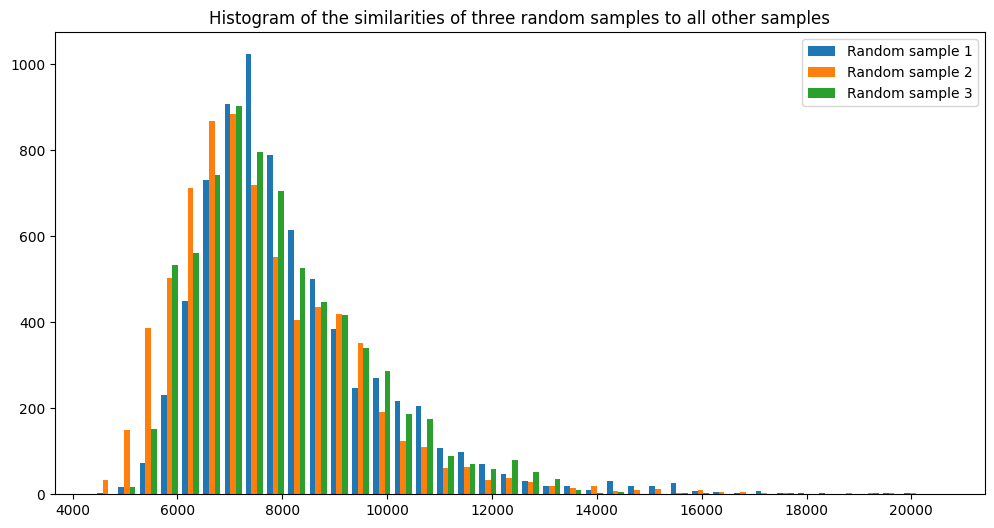

In [4]:
sim_single = np.dot(X_fixed[np.random.randint(low=0, high=42*72, size=3),:], X_fixed.T)
plt.figure(figsize=(12,6))
plt.hist(sim_single.T, bins=40)
plt.legend(["Random sample 1", "Random sample 2", "Random sample 3"])
plt.title("Histogram of the similarities of three random samples to all other samples")
plt.show()

### Train-test split
There are 72 frames for each object. Let's go ahead and decide how many samples per class we want to provide for training. 
If we wish, we can dataset by the factor ```k_sample```, as the consecutive image frames are very similar. In this case, we will sample by a factor of 2 (36 frames per object). We will reserve ten frames for training and 26 for testing for our first experiment, i.e., the multi-shot supervised CL.

In [5]:
from sklearn.model_selection import train_test_split

# Subsample the dataset
k_sample = 2
X_sampled = X_fixed[::k_sample, :]
y_sampled = y[::k_sample]

test_size = 26/36
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=test_size, random_state=1000, stratify=y_sampled)

### Ordering of the data: non-i.i.d. stream learning
Next, we will order the training and testing samples by the objects. This way, we simulate online sequential learning. Note that this data order is non-i.i.d, as there is no shuffling among the objects. However, each object's frames are shuffled separately in the previous cell.

In [6]:
X_train = X_train[np.argsort(y_train),:]
y_train = y_train[np.argsort(y_train)]
X_test = X_test[np.argsort(y_test),:]
y_test = y_test[np.argsort(y_test)]

Additionally, we can choose how many objects we want to learn out of 100 objects available in the dataset. We have chosen 20 objects for initial training as the full dataset takes a long to run in CPU simulation. But if the simulation takes a long time, you can decrease it further.

In [7]:
cls_rng = [0, 20]
n_classes = cls_rng[1]

X_train = X_train[(y_train>cls_rng[0]) & (y_train<=cls_rng[1]), :]
X_test = X_test[(y_test>cls_rng[0]) & (y_test<=cls_rng[1]), :]
y_train = y_train[(y_train>cls_rng[0]) & (y_train<=cls_rng[1])]
y_test = y_test[(y_test>cls_rng[0]) & (y_test<=cls_rng[1])]

print(X_train.shape)
print(X_test.shape)

(200, 1280)
(520, 1280)


### Visualization of the similarity between the training and testing samples
Below, we visualize the similarity between training samples (rows) and testing samples (columns). Dark red diagonal entries point to small intra-class variance, while the lighter entries along the diagonal mean those classes have higher intra-class variability. We also observe bright off-diagonal entries, possibly highlighting high similarity/confusion between the corresponding objects.

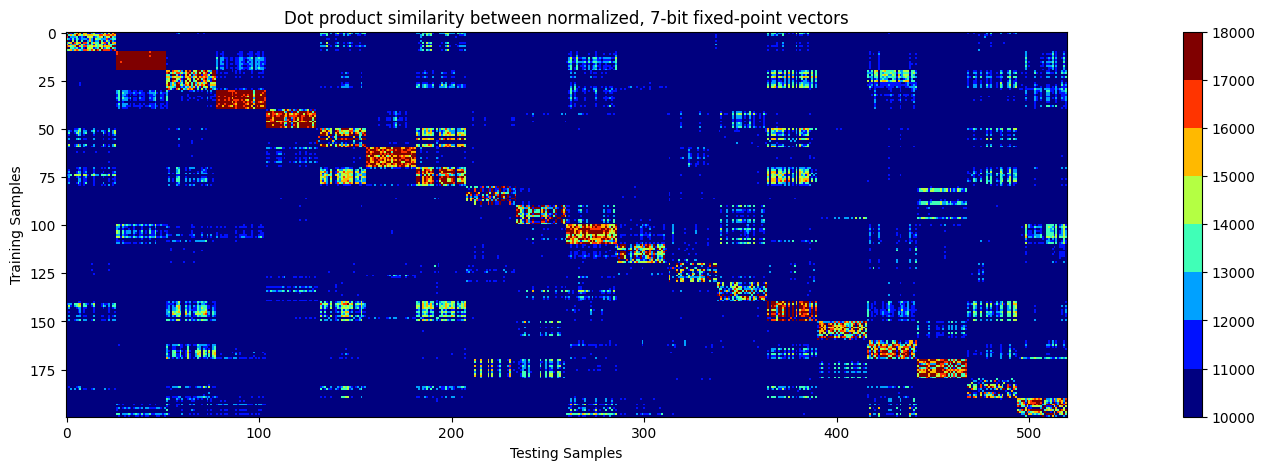

In [8]:
from matplotlib import colors

a_in = np.arange(10000,19000, 1000)

sims = np.dot(X_train, X_test.T)

# define the colormap
cmap = plt.cm.jet  

# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

bounds=a_in
norm = colors.BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(30,5))
img = plt.imshow(sims, interpolation='nearest',cmap=cmap, norm=norm)
plt.colorbar(img, cmap=cmap, norm=norm, boundaries=bounds, ticks=a_in)
plt.title("Dot product similarity between normalized, 7-bit fixed-point vectors")
plt.xlabel("Testing Samples")
plt.ylabel("Training Samples")
plt.show()

## Lava diagram of CLP for COIL-100 experiment

<center><img src="https://raw.githubusercontent.com/lava-nc/lava-nc.github.io/main/_static/images/tutorial_clp/clp_coil100_lava_diagram.png" style="width:90%"><center>
<center><figcaption align = "center"> Figure 1. Lava process diagram of the CLP that is capable of both unsupervised and supervised learning </figcaption><center>

Compared to the introductory CLP tutorial, we are using an upgraded version of the algorithm here. Specifically, this version is concurrently capable of both unsupervised and supervised learning. This is possible thanks to error feedback from the ```Readout``` process to the ```Allocator``` process. Basically, when there is a mismatch between the predicted label and the user-provided true label, the ```Readout``` process generates an error signal, which triggers the allocation of a new prototype neuron for this mistaken pattern. As we will see later, this will improve the performance. This error feedback can be turned on or off, and based on this the CLP performs either supervised or unsupervised learning.

## Temporal Winner-take-all 

To facilitate a somewhat precise competition between similar prototypes, we need a temporal winner-take-all mechanism, where the best matching prototype neuron should spike first and inhibit others by sending them a hard-reset signal. This is also shown in the above diagram. However, we need to tune the voltage threshold, current and voltage decay constants of these neurons so that similar prototypes do not spike at the same time step but have at least one time step difference. For this purpose we want some input current ranges to trigger output spikes at different time steps.

#### (Optional) Hyperparameter search for PrototypeLIF

To achieve this, we can do a hyperparameter search on ```du, dv, vth``` so that each input current value from the list of ```[12000, 13200, 14400, 15600, 16800, 18000]``` elicit output spike at a unique time step. Note that we need a minimum current value that does not elicit a spike and it should be a little smaller than the minimum value in the range above. As this hyperparameter search takes time, we have commented it out, but one can rerun this search for other input current values. 

In [67]:
# from utils import wta_hyperparam_search
# a_in = [11900]+list(range(12000,18800, 1200))
# print(a_in)
# n_steps = 25
# best_params = wta_hyperparam_search(a_in, n_steps)

-----------------------------
du = 10
dv = 760
vth = 61000
The Latest spike time: 18
-----------------------------
du = 30
dv = 600
vth = 70000
The Latest spike time: 16
-----------------------------
du = 50
dv = 620
vth = 64000
The Latest spike time: 14
-----------------------------
du = 70
dv = 740
vth = 53000
The Latest spike time: 12
Spike time for neuron 1 with a_in=11900: 0
Spike time for neuron 2 with a_in=12000: 12
Spike time for neuron 3 with a_in=13200: 7
Spike time for neuron 4 with a_in=14400: 6
Spike time for neuron 5 with a_in=15600: 5
Spike time for neuron 6 with a_in=16800: 4
Spike time for neuron 7 with a_in=18000: 3
Best Parameter Combination:
du = 70
dv = 740
vth = 53000


#### Visualize voltage dynamics
Let's also visualize the voltage dynamics with the chosen hyperparameters for the input values we wanted to distinguish in the temporal domain.

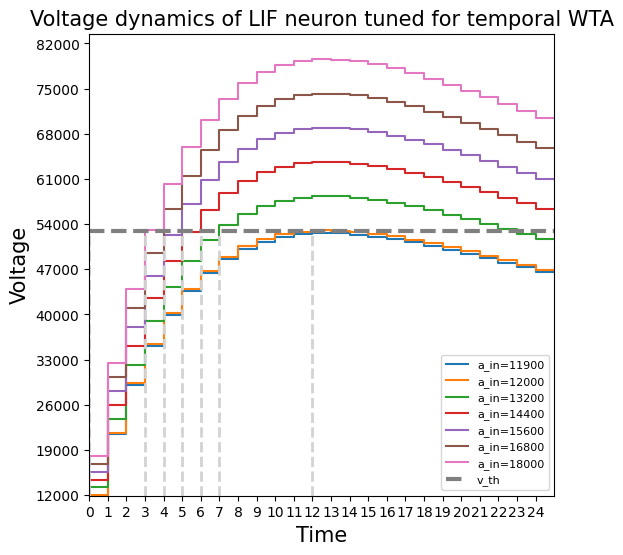

In [9]:
from utils import plot_wta_voltage_dynamics
n_steps = 25

# Input values to differentiate based on spike time
a_in = [11900]+list(range(12000,18800, 1200))

# Optimized hyperparameters
du = 70
dv = 740
vth = 53000

plot_wta_voltage_dynamics(du, dv, vth, a_in, n_steps)

## Offline Supervised Baselines: K-NN accuracy

Before going into the CLP experiments, let's find a baseline accuracy. For this purpose, we used k-NN (k=1), the simplest and one of the most well-known prototype-based approaches. Below, we report the offline K-NN (k=1) accuracy is 97.6%. Note that this accuracy can be further improved by using more sophisticated algorithms, but as the dataset is relatively simple, the accuracy is already quite high. Another rationale behind using K-NN is that it is a brute-force and simple version of the current CLP algorithm, as K-NN stores all data, while CLP stores only those that are novel or have triggered a prediction error. We also chose ```n=1``` because CLP uses a single winner-take-all mechanism, and using ```n=1``` for K-NN has a similar effect that the prediction is based on the most similar pattern stored in memory.

Offline KNN accuracy (k=1): 0.971


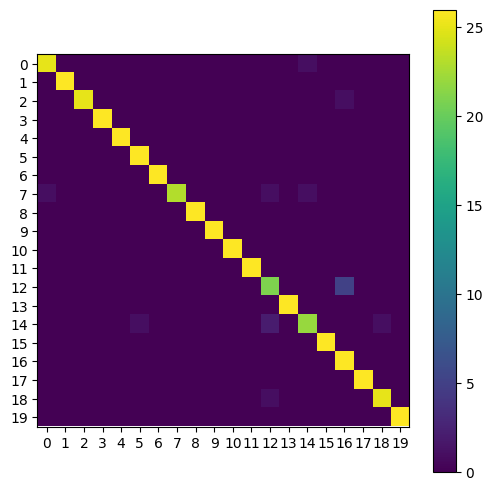

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

knn = KNeighborsClassifier(n_neighbors=1, metric='cosine')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Offline KNN accuracy (k=1):", acc.round(3))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
plt.xticks(np.arange(cls_rng[1]))
plt.yticks(np.arange(cls_rng[1]))
plt.imshow(cm)
plt.colorbar()
plt.show()

## Setup the CLP network

Now, let's set up our CLP network.

We initialize the CLP object with the global and process-specific parameters. Specifically, ```supervised``` is a flag allowing allocation of new prototypes based on the supervision signal of the user (supervised learning), while ```learn_novels``` allows allocation based on novelty detection (unsupervised). If both are set to false, then the system is in pure inference mode with no learning. 

```n_protos``` is the number of the prototypes, ```n_features``` is the length of the input feature vector, ```n_steps_per_sample``` is the number of steps needed to process each input sample, ```b_fraction``` is the number of the bits for fixed representation of the input.

In addition, ```du```, ```dv```, ```vth``` are ```PrototypeLIF``` parameters that are taken from the above WTA hyperparameter optimization, while ```t_wait``` is the ```NoveltyDetector``` parameter that specifies the number of time steps to wait for a PrototypeLIF before declaring the input pattern a novel one. It is set based on the result of the hyperparameter optimization (see above), i.e., the spike time of the latest spike possible after input injection.

Finally, setting the ```debug``` parameter runs the CLP in debug mode, where current and voltage values are recorded. Here, we are not using this functionality.

We also define run configuration here, which will be shared throughout our experiments.

In [11]:
# General params
n_features = X_train.shape[1]
t_wait = 13  # the waiting window for novelty detection after input injection
n_protos = 100  # number of the prototypes
# The time difference between two consecutive inputs
n_steps_per_sample = t_wait + 8  # To give enough time for dynamics to converge

# PrototypeLIF neural dynamics parameters
du = 70
dv = 740
vth = 53000
exception_map = {
        LearningDense: PyLearningDenseModelBitApproximate
}

run_cfg = Loihi2SimCfg(select_tag="fixed_pt",
                       exception_proc_model_map=exception_map)

## Experiment 1: Multi-shot supervised Online Continual Learning (OCL)

In the multi-shot supervised learning experiment, we enable both the novelty-triggered and error signal-trigger allocation. We provide ten samples (multi-shot) per object for training and each training sample is provided with the label. As a result, If a novelty is detected, it triggers an allocation and the new prototype is labelled with the provided label. On the other hand, if there is a prediction and the predicted label does not match the true label, an error signal is generated to trigger the allocation of a new prototype with the correct label. If the prediction matches the actual label, we take no action.

### Initialize the CLP network

After initializing parameters in the previous step, using them, we create an instance of the CLP class, which is a wrapper around processes, connections and helper functions of the entire CLP system. Next, we run the ```generate_input_spikes()``` function to generate input spikes for the whole run: both input pattern spikes and label input spikes. ```setup_procs_and_conns()``` function initializes all the necessary processes of the CLP and connects them. In addition, the ```get_results()``` function reads the collected results from the monitors. These are the predictions and spike times for novelty, prototype and error spikes. If the ```debug``` mode is on, you can also get prototype neurons' current and voltage values.

### Training phase

For the training phase of this experiment we set both parameter ```supervised``` and ```learn_novels``` true.

In [12]:
from clp import CLP

clp = CLP(supervised=True,
          learn_novels=True,
          n_protos=n_protos,
          n_features=n_features,
          n_steps_per_sample=n_steps_per_sample,
          b_fraction=b_fraction,
          du=du,
          dv=dv,
          vth=vth,
          t_wait=t_wait,
          debug=False)

s_pattern_inp, s_user_label = clp.generate_input_spikes(X_train, y_train)
clp = clp.setup_procs_and_conns()

num_steps = clp.num_steps

In [13]:
# Run

run_cond = RunSteps(num_steps=num_steps)

clp.prototypes.run(condition=run_cond, run_cfg=run_cfg)

novelty_spikes, proto_spikes, error_spikes, preds, currs = clp.get_results()


Let's visualize output spikes for the novelty, error and the first 10 prototype neurons and the output of the readout process as our main prediction.

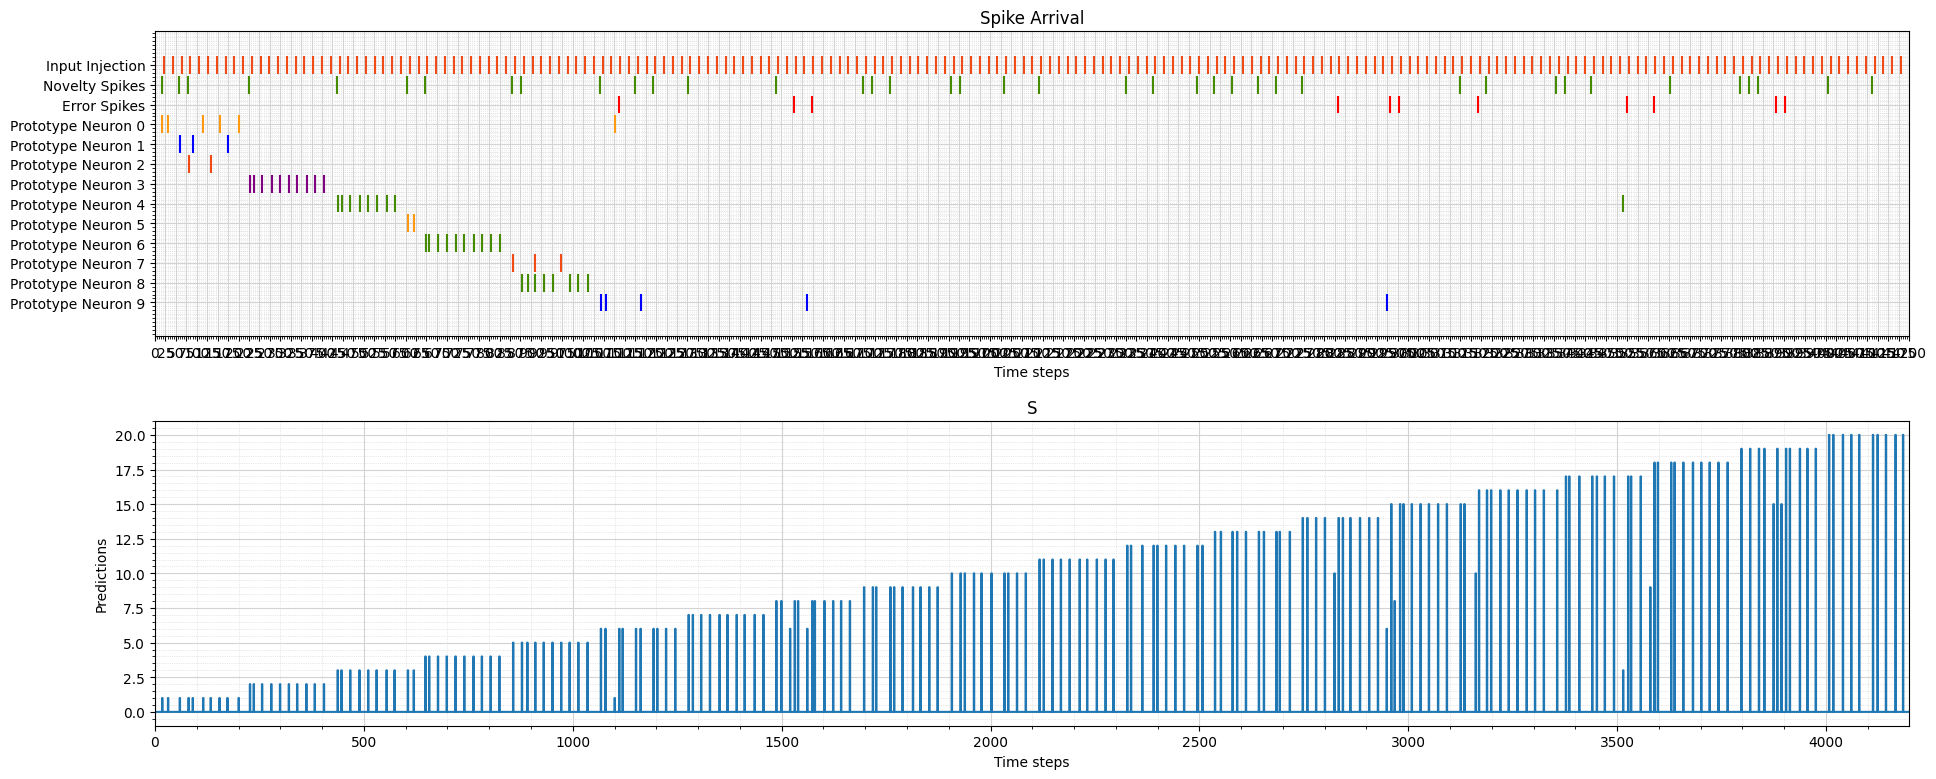

In [16]:
from utils import  plot_spikes, plot_spikes_time_series
time = np.arange(num_steps)
plot_spikes_time_series(
        spikes=[np.where(proto_spikes[:, 9])[0],
                np.where(proto_spikes[:, 8])[0],
                np.where(proto_spikes[:, 7])[0],
                np.where(proto_spikes[:, 6])[0],
                np.where(proto_spikes[:, 5])[0],
                np.where(proto_spikes[:, 4])[0],
                np.where(proto_spikes[:, 3])[0],
                np.where(proto_spikes[:, 2])[0],
                np.where(proto_spikes[:, 1])[0],
                np.where(proto_spikes[:, 0])[0],
                np.where(error_spikes)[0],
                np.where(novelty_spikes)[0],
                np.where(s_pattern_inp[0, :])[0]],
        time_series=preds,
        y_label_time_series = 'Predictions',
        time=time,
        figsize=(20, 8),
        legend=['Prototype Neuron 9', 'Prototype Neuron 8',
                'Prototype Neuron 7', 'Prototype Neuron 6',
                'Prototype Neuron 5', 'Prototype Neuron 4',
                'Prototype Neuron 3', 'Prototype Neuron 2',
                'Prototype Neuron 1', 'Prototype Neuron 0', 
                'Error Spikes', 'Novelty Spikes', 'Input Injection'],
        colors=['blue', '#458b00', '#f14a16', '#458b00', '#ff9912', '#458b00', 'purple', '#f14a16', 'blue', '#ff9912','r','#458b00', '#f14a16', '#458b00'],
        title='Spike Raster Plot',
        num_steps=num_steps
)

### Testing phase
We turn off both novelty and error-triggered allocation mechanisms to evaluate the model.

In [17]:
clp.supervised = False
clp.learn_novels = False

s_pattern_inp, s_user_label = clp.generate_input_spikes(X_test)
clp = clp.setup_procs_and_conns()

num_steps = clp.num_steps

# Run
run_cond = RunSteps(num_steps=num_steps)

clp.prototypes.run(condition=run_cond, run_cfg=run_cfg)

novelty_spikes, proto_spikes, error_spikes, preds,currs = clp.get_results()


#### Performance results

Below, we calculate the accuracy of the test set (26 frames per object) after the learning is finished. As expected, the results are near to offline K-NN results. We also break down the error into two components: confusion between the learned classes and false positive novelty detections (i.e., not responding to some instances). One can observe that the confusion rate is precisely the same as offline KNN results. However, because the prototype in CLP has detection thresholds, they may misclassify some known instances as unknowns. This can be solved by tuning the hyperparameters like voltage threshold, however, we need to hit a balance between 

Test accuracy on offline trained classes (including no response cases):  0.894
Error rate on test set (excluding no response cases):  0.038
False positive rate for novelty detection:  0.067


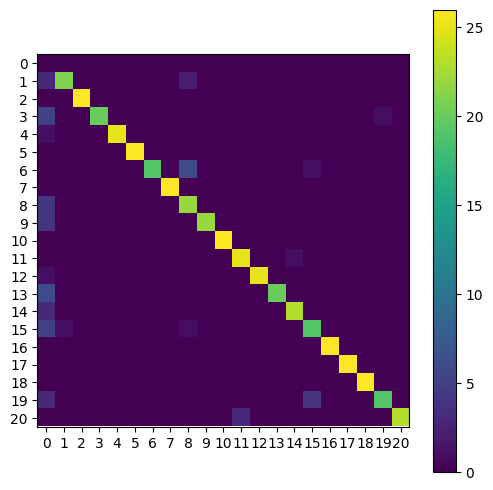

In [18]:
y_pred = np.maximum.reduceat(preds.copy(), np.r_[0:len(preds):n_steps_per_sample])[:,0]
novelty_pred = np.maximum.reduceat(novelty_spikes.copy(), np.r_[0:len(novelty_spikes):n_steps_per_sample])[:,0]

acc = accuracy_score(y_test, y_pred).round(3)
print("Test accuracy on offline trained classes (including no response cases): ", acc)

err_rate = (np.sum(y_pred[y_pred!=0] != y_test[y_pred!=0])/len(y_test)).round(3)
print("Error rate on test set (excluding no response cases): ", err_rate)

y_known = np.zeros(shape=y_test.shape)
nvl_FP = (1-accuracy_score(y_known, novelty_pred)).round(3)
print("False positive rate for novelty detection: ", nvl_FP)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
plt.xticks(np.arange(cls_rng[1]+1))
plt.yticks(np.arange(cls_rng[1]+1))
plt.imshow(cm)
plt.colorbar()
plt.show()

## Experiment 2: Novelty detection of unknown classes

In this experiment, we will evaluate the novelty detection capability on unknown classes and see how many per cent of the frames from the ten unknown classes can be detected as a novelty after we have learnt the first 20 classes above.

In [19]:
## OOD detection data prep
cls_rng = [20, 30]
n_classes = cls_rng[1]

X_ood = X_sampled[(y_sampled>cls_rng[0]) & (y_sampled<=cls_rng[1]), :]
y_ood = y_sampled[(y_sampled>cls_rng[0]) & (y_sampled<=cls_rng[1])]

X_ood = X_ood[np.argsort(y_ood),:]
y_ood = y_ood[np.argsort(y_ood)]

print(X_ood.shape)
print(y_ood.shape)

(360, 1280)
(360,)


In [20]:
clp.supervised = False
clp.learn_novels = False

s_pattern_inp, s_user_label = clp.generate_input_spikes(X_ood)
clp = clp.setup_procs_and_conns()

num_steps = clp.num_steps

# Run
run_cond = RunSteps(num_steps=num_steps)

clp.prototypes.run(condition=run_cond, run_cfg=run_cfg)

novelty_spikes, proto_spikes, error_spikes, preds, _ = clp.get_results()

In [22]:
novelty_pred = np.maximum.reduceat(novelty_spikes.copy(), np.r_[0:len(novelty_spikes):n_steps_per_sample])

y_unknown = np.ones(shape=y_ood.shape)
print("Correct novelty detection rate: ", accuracy_score(y_unknown, novelty_pred).round(3))

Correct novelty detection rate:  0.681


## Experiment 3: Few-shot open-set unsupervised OCL
This experiment will test learning novel classes on top of base classes. We simulate real-world dynamic learning by presenting the model with familiar and novel classes. The error-based allocation mechanism is turned off: the learning happens only through novelty detection triggered allocation, hence unsupervised. The prototypes allocated via this mechanism receive a temporary pseudo-label, which can be updated later with actual labels. We provide labels for all training examples to simulate this kind of post-labelling. However, they do not trigger learning themselves but are used to label newly allocated prototypes just after their allocation. For each object (class), 1, 5 or 10 frames are provided for training to test few-shot learning performance. The test set includes all 20 base classes and 10 novel classes to measure accuracy for both groups of classes. 


### Data preperation
We reserve 10 frames for training, however we will use 1, 5 or all of them to train model in different versions of the few-shot learning experiment.

In [14]:
test_size = 26/36
X_train_on, X_test_on, y_train_on, y_test_on = train_test_split(X_sampled, y_sampled, test_size=test_size, random_state=1000, stratify=y_sampled)

X_train_on = X_train_on[np.argsort(y_train_on),:]
y_train_on = y_train_on[np.argsort(y_train_on)]
X_test_on = X_test_on[np.argsort(y_test_on),:]
y_test_on = y_test_on[np.argsort(y_test_on)]

cls_rng = [20, 30]
n_classes = cls_rng[1]

X_train_on = X_train_on[(y_train_on>cls_rng[0]) & (y_train_on<=cls_rng[1]), :]
X_test_on = X_test_on[(y_test_on>cls_rng[0]) & (y_test_on<=cls_rng[1]), :]
y_train_on = y_train_on[(y_train_on>cls_rng[0]) & (y_train_on<=cls_rng[1])]
y_test_on = y_test_on[(y_test_on>cls_rng[0]) & (y_test_on<=cls_rng[1])]

print(X_train_on.shape)
print(X_test_on.shape)

(100, 1280)
(260, 1280)


### Save the model
The model is saved by storing learned prototypes and their labels because we will do multiple experiments on the same base model.

In [15]:
proto_labels = clp.readout_layer.proto_labels.get()
weights_proto = clp.dense_proto.weights.get()
clp.prototypes.stop()

### Train and test

The main training and testing loop for ```k = [1,5,10]``` of three experiments.
```supervised``` parameter is turned off to make learning the novel ten classes purely unsupervised. For testing, ```learn_novels``` is turned off too. For all three experiments, the same saved base model is used.

In [56]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

old_class_accs = []
inc_class_accs = []
total_accs = []

k_shot_list = [1, 5, 10]

for k_shot in k_shot_list:
    
    X_train_k_shot = np.reshape(X_train_on, (-1, 10, X_train_on.shape[-1]))[:, :k_shot].reshape((-1, X_train_on.shape[-1])) 
    X_test_k_shot = np.reshape(X_test_on, (-1, 10, X_test_on.shape[-1]))[:, :k_shot].reshape((-1, X_test_on.shape[-1]))
    y_train_k_shot = np.reshape(y_train_on, (-1, 10))[:, :k_shot].reshape((-1,))
    y_test_k_shot = np.reshape(y_test_on, (-1, 10,))[:, :k_shot].reshape((-1,))

    # #------------- Incremental training ------------#

    clp = CLP(supervised=False,
              learn_novels=True,
              weights_proto=weights_proto,
              proto_labels=proto_labels,
              n_protos=n_protos,
              n_features=n_features,
              n_steps_per_sample=n_steps_per_sample,
              b_fraction=b_fraction,
              du=du,
              dv=dv,
              vth=vth,
              t_wait=t_wait)
    s_pattern_inp, s_user_label = clp.generate_input_spikes(X_train_k_shot, y_train_k_shot)
    clp = clp.setup_procs_and_conns()
    
    num_steps = clp.num_steps
    
    # Run
    run_cond = RunSteps(num_steps=num_steps)
    
    clp.prototypes.run(condition=run_cond, run_cfg=run_cfg)

    #---------------- Testing -----------------------#

    clp.supervised = False
    clp.learn_novels = False
    
    s_pattern_inp, s_user_label = clp.generate_input_spikes(np.vstack((X_test, X_test_on)))
    clp = clp.setup_procs_and_conns()
    
    num_steps = clp.num_steps
    
    # Run
    run_cond = RunSteps(num_steps=num_steps)
    clp.prototypes.run(condition=run_cond, run_cfg=run_cfg)
    
    novelty_spikes, proto_spikes, error_spikes, preds, currs = clp.get_results()
    y_pred = np.maximum.reduceat(preds.copy(), np.r_[0:len(preds):n_steps_per_sample])

    old_cls_acc = accuracy_score(y_test, y_pred[:len(y_test)])
    new_cls_acc = accuracy_score(y_test_on, y_pred[len(y_test):])

    y_all = np.concatenate((y_test,y_test_on))
    total_acc = accuracy_score(y_all, y_pred)
    
    print("k = " ,k_shot)
    print("Accuracy for old classes: ", old_cls_acc.round(3))
    print("Accuracy for new classes: ", new_cls_acc.round(3))
    print("Total accuracy: ", total_acc.round(3))
    print("--------------------------------")

    old_class_accs.append(old_cls_acc)
    inc_class_accs.append(new_cls_acc)
    total_accs.append(total_acc)
    
    clp.prototypes.stop()
    
old_class_accs = np.array(old_class_accs)
inc_class_accs = np.array(inc_class_accs)
total_accs = np.array(total_accs) 

k =  1
Accuracy for old classes:  0.894
Accuracy for new classes:  0.404
Total accuracy:  0.731
--------------------------------
k =  5
Accuracy for old classes:  0.894
Accuracy for new classes:  0.738
Total accuracy:  0.842
--------------------------------
k =  10
Accuracy for old classes:  0.894
Accuracy for new classes:  0.754
Total accuracy:  0.847
--------------------------------


### Visualize the results

Below we visualize the results from the experiment. Three types of accuracies (for base classes, novel classes and combined) are plotted for all three values of k (1, 5 and 10-shot). The following observation can be made from the results:
- Accuracy of the 20 base classes does not drop after learning ten novel classes, i.e., no forgetting occurred.
- Unsupervised 1-shot and 5-shot learning accuracies of novel classes are compelling but does not reach supervised multi-shot learning levels
- More shots, i.e., more frames for training each object, helps to increase this accuracy almost to the supervised levels.

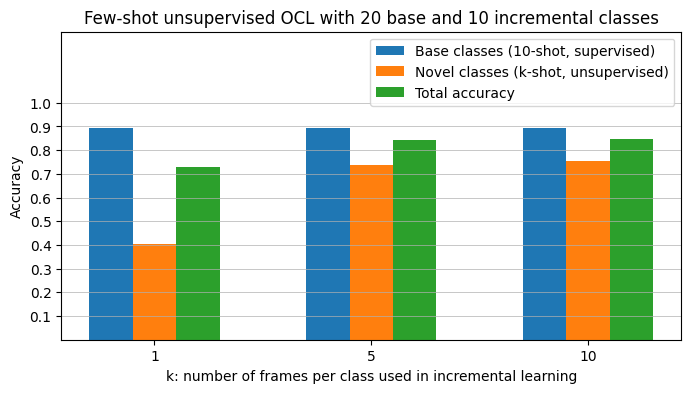

In [57]:
plt.figure(figsize=(8,4))
X_axis = np.arange(3)
plt.bar(X_axis-0.2, old_class_accs, 0.2, label='Base classes (10-shot, supervised)')
plt.bar(X_axis, inc_class_accs, 0.2, label='Novel classes (k-shot, unsupervised)')
plt.bar(X_axis+0.2, total_accs, 0.2, label='Total accuracy')

plt.ylim([0,1.3])
plt.xticks(X_axis, k_shot_list)
plt.yticks(np.arange(0.1,1.1,0.1))
plt.grid(linewidth=0.5, axis='y')

plt.title("Few-shot unsupervised OCL with 20 base and 10 incremental classes")
plt.xlabel("k: number of frames per class used in incremental learning")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Old classes' accuracy:  0.8942307692307693
New classes' accuracy:  0.7538461538461538
Accuracy:  0.8474358974358974


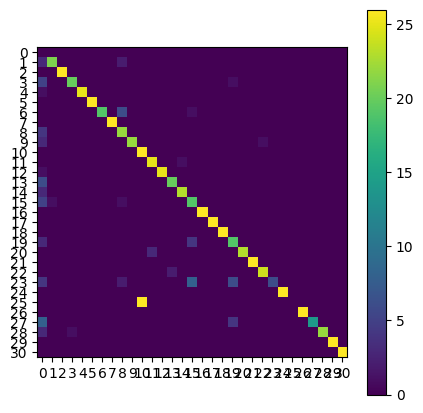

In [58]:
y_pred = np.maximum.reduceat(preds.copy(), np.r_[0:len(preds):n_steps_per_sample])

print("Old classes' accuracy: ", accuracy_score(y_test, y_pred[:len(y_test)]))
print("New classes' accuracy: ", accuracy_score(y_test_on, y_pred[len(y_test):]))
y_all = np.concatenate((y_test,y_test_on))
acc = accuracy_score(y_all, y_pred)
print("Accuracy: ", acc)

cm = confusion_matrix(y_all, y_pred)
plt.figure(figsize=(5,5))
plt.xticks(np.arange(n_classes+1))
plt.yticks(np.arange(n_classes+1))
plt.imshow(cm)
plt.colorbar()
plt.show()

## Experiment 4: Few-shot supervised OCL

This experiment will extend Experiment 1 into a few-shot learning regime. Like Experiment 3, the model will learn ten novel classes on top of the base model that already knows the 20 objects. However, this time, we will provide labels for training: every time a wrong prediction is made, the error signal triggers allocation, hence learning. Note that the novelty detection triggered learning is still in place with the labelling mechanism. 

### Train and Test

In [37]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

old_class_accs = []
inc_class_accs = []
total_accs = []

k_shot_list = [1, 5, 10]

for k_shot in k_shot_list:
    
    X_train_k_shot = np.reshape(X_train_on, (-1, 10, X_train_on.shape[-1]))[:, :k_shot].reshape((-1, X_train_on.shape[-1])) 
    X_test_k_shot = np.reshape(X_test_on, (-1, 10, X_test_on.shape[-1]))[:, :k_shot].reshape((-1, X_test_on.shape[-1]))
    y_train_k_shot = np.reshape(y_train_on, (-1, 10))[:, :k_shot].reshape((-1,))
    y_test_k_shot = np.reshape(y_test_on, (-1, 10,))[:, :k_shot].reshape((-1,))

    # #------------- Incremental training ------------#

    clp = CLP(supervised=True,
              learn_novels=True,
              weights_proto=weights_proto,
              proto_labels=proto_labels,
              n_protos=n_protos,
              n_features=n_features,
              n_steps_per_sample=n_steps_per_sample,
              b_fraction=b_fraction,
              du=du,
              dv=dv,
              vth=vth,
              t_wait=t_wait)
    s_pattern_inp, s_user_label = clp.generate_input_spikes(X_train_k_shot, y_train_k_shot)
    clp = clp.setup_procs_and_conns()
    
    num_steps = clp.num_steps
    
    # Run
    run_cond = RunSteps(num_steps=num_steps)
    
    clp.prototypes.run(condition=run_cond, run_cfg=run_cfg)

    #---------------- Testing -----------------------#

    clp.supervised = False
    clp.learn_novels = False
    
    s_pattern_inp, s_user_label = clp.generate_input_spikes(np.vstack((X_test, X_test_on)))
    clp = clp.setup_procs_and_conns()
    
    num_steps = clp.num_steps
    
    # Run
    run_cond = RunSteps(num_steps=num_steps)
    clp.prototypes.run(condition=run_cond, run_cfg=run_cfg)
    
    novelty_spikes, proto_spikes, error_spikes, preds, currs = clp.get_results()
    y_pred = np.maximum.reduceat(preds.copy(), np.r_[0:len(preds):n_steps_per_sample])

    old_cls_acc = accuracy_score(y_test, y_pred[:len(y_test)])
    new_cls_acc = accuracy_score(y_test_on, y_pred[len(y_test):])

    y_all = np.concatenate((y_test,y_test_on))
    total_acc = accuracy_score(y_all, y_pred)
    
    print("k = " ,k_shot)
    print("Accuracy for old classes: ", old_cls_acc.round(3))
    print("Accuracy for new classes: ", new_cls_acc.round(3))
    print("Total accuracy: ", total_acc.round(3))
    print("--------------------------------")

    old_class_accs.append(old_cls_acc)
    inc_class_accs.append(new_cls_acc)
    total_accs.append(total_acc)
    
    clp.prototypes.stop()
    
old_class_accs = np.array(old_class_accs)
inc_class_accs = np.array(inc_class_accs)
total_accs = np.array(total_accs) 

k =  1
Accuracy for old classes:  0.894
Accuracy for new classes:  0.5
Total accuracy:  0.763
--------------------------------
k =  5
Accuracy for old classes:  0.894
Accuracy for new classes:  0.885
Total accuracy:  0.891
--------------------------------
k =  10
Accuracy for old classes:  0.894
Accuracy for new classes:  0.915
Total accuracy:  0.901
--------------------------------


### Visualize the results

Similar to Experiment 3, we visualize the results in a bar plot. Subsequently, we make the following observations:
- Still no forgetting of old knowledge (blue), even when labels are used during training.
- Regarding 1-shot learning, supervision does not improve the accuracy of novel classes much compared to the unsupervised version.
- However, with 5-shot and supervision, the performance improves significantly: it reaches similar levels to the base classes and surpasses the unsupervised version, as expected.
- Adding five more frames on top of this (i.e. 10-shot) does not bring much extra improvement.

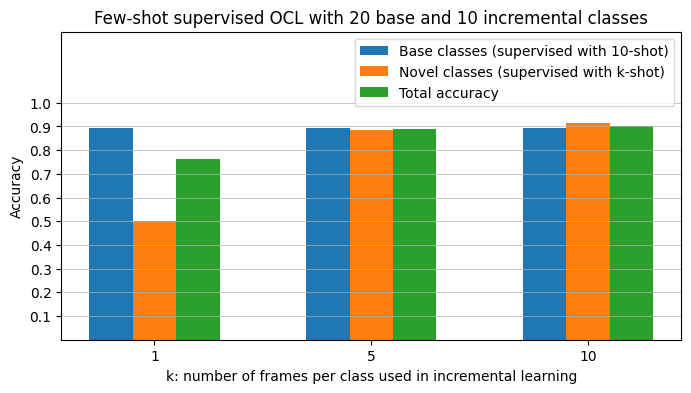

In [55]:
plt.figure(figsize=(8,4))
X_axis = np.arange(3)
plt.bar(X_axis-0.2, old_class_accs, 0.2, label='Base classes (10-shot, supervised)')
plt.bar(X_axis, inc_class_accs, 0.2, label='Novel classes (k-shot, supervised)')
plt.bar(X_axis+0.2, total_accs, 0.2, label='Total accuracy')

plt.ylim([0,1.3])
plt.xticks(X_axis, k_shot_list)
plt.yticks(np.arange(0.1,1.1,0.1))
plt.grid(linewidth=0.5, axis='y')

plt.title("Few-shot supervised OCL with 20 base and 10 incremental classes")
plt.xlabel("k: number of frames per class used in incremental learning")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Old classes' accuracy:  0.8942307692307693
New classes' accuracy:  0.9153846153846154
Accuracy:  0.9012820512820513


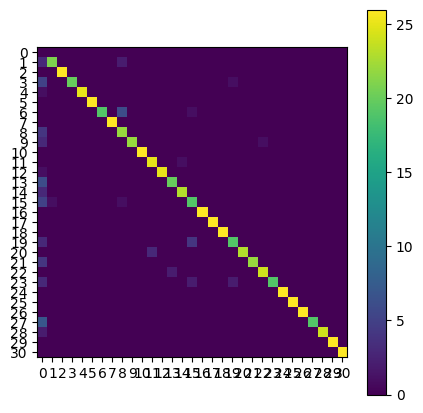

In [42]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_pred = np.maximum.reduceat(preds.copy(), np.r_[0:len(preds):n_steps_per_sample])

print("Old classes' accuracy: ", accuracy_score(y_test, y_pred[:len(y_test)]))
print("New classes' accuracy: ", accuracy_score(y_test_on, y_pred[len(y_test):]))
y_all = np.concatenate((y_test,y_test_on))
acc = accuracy_score(y_all, y_pred)
print("Accuracy: ", acc)

cm = confusion_matrix(y_all, y_pred)
plt.figure(figsize=(5,5))
plt.xticks(np.arange(n_classes+1))
plt.yticks(np.arange(n_classes+1))
plt.imshow(cm)
plt.colorbar()
plt.show()

## How to learn more?

Learn about details of CLP algorithms and its main processes in the [introductory in-depth tutorial on CLP](./tutorial01_one-shot_learning_with_novelty_detection.ipynb "Introduction to CLP").

If you want to find out more about CLP, have a look at the [Lava documentation](https://lava-nc.org/ "Lava Documentation") or dive into the [source code](https://github.com/lava-nc/lava/tree/main/src/lava/proc/clp "Process Source Code").

To receive regular updates on the latest developments and releases of the Lava Software Framework please subscribe to the [INRC newsletter](http://eepurl.com/hJCyhb "INRC Newsletter").